# Inverse Design of a Waveguide Crossing using S-Matrix Optimization

In this notebook, we will use inverse design to create a compact, high-performance waveguide crossing. This device is a fundamental component in photonic integrated circuits, allowing two separate optical signals in different waveguides to cross each other with minimal signal loss and crosstalk.

Instead of manually designing the structure, we will use an **adjoint optimization** method. We'll start by defining the *function* we want the device to perform in terms of its scattering matrix (S-matrix). Then, we will use `tidy3d`'s automatic differentiation capabilities to discover a geometric structure that achieves this function.

This example highlights the use of the `tidy3d.plugins.smatrix.ComponentModeler`, a powerful tool for optimizing devices based on their multi-port scattering properties. It simplifies the process by automatically running the necessary simulations to compute the full S-matrix, which we can then use directly in our objective function. For more details on the `ComponentModeler`, see [this tutorial](https://docs.flexcompute.com/projects/tidy3d/en/latest/notebooks/SMatrix.html).

If you are new to inverse design, we recommend our tutorials on the [Learning Center](https://www.flexcompute.com/tidy3d/learning-center/inverse-design/) and our [primer on automatic differentiation with tidy3d](https://www.flexcompute.com/tidy3d/examples/notebooks/Autograd1Intro/).

In [1]:
import autograd as ag
import autograd.numpy as np
import matplotlib.pylab as plt
import tidy3d as td

np.random.seed(2)

## Setup

First, we define the basic parameters for our simulation.

Our device will consist of two parallel input waveguides and two parallel output waveguides. Between them lies a rectangular "design region." We will optimize the pixel-by-pixel permittivity within this region to make light from the top input guide cross over to the bottom output guide, and light from the bottom input guide cross to the top output guide.

This example is a 2D simulation for speed and reduced FlexCredit usage, but it can be easily extended to 3D by defining a vertical dimension (`Lz`), adding a substrate, and modifying the structures accordingly.

In [2]:
# material information
n_si = 3.49
n_air = 1

# source
wvl0 = 1.5
freq0 = td.C_0 / wvl0
fwidth = freq0 / 10
run_time = 200 / fwidth

# size of waveguides
wg_width = 0.3
wg_length = 1.5
wg_spacing = 1.5


# size of design region
lx = 4.5
ly = 4.5
lz = td.inf

# spacing between design region and PML in y
buffer = 1.5

# size of simulation
Lx = lx + wg_length * 2
Ly = Lx
Lz = 0.0

# fabrication constraints (feature size and projection strength)
radius = 0.150
beta0 = 2

# resolution information
min_steps_per_wvl = 18
dl_design_region = 0.01

### Static Simulation

Before we define the optimizable design region, we will set up the "static" parts of the simulation—the components that do not change during the optimization. These include the input and output waveguides and the ports used to inject and measure light.

In [3]:
wg_vert = td.Structure(
    geometry=td.Box(
        center=(0, 0, 0),
        size=(td.inf, wg_width, lz),
    ),
    medium=td.Medium(permittivity=n_si**2),
)

wg_horz = td.Structure(
    geometry=td.Box(
        center=(0, 0, 0),
        size=(wg_width, td.inf, lz),
    ),
    medium=td.Medium(permittivity=n_si**2),
)

wgs = [wg_vert, wg_horz]

fld_mnt_name = "field"

# field monitor that measures fields on the z=0 plane at the design freqs
fld_mnt = td.FieldMonitor(
    center=(0, 0, 0),
    size=(td.inf, td.inf, 0),
    freqs=[freq0],
    name=fld_mnt_name,
)

sim_static = td.Simulation(
    size=(Lx, Ly, Lz),
    grid_spec=td.GridSpec.auto(
        min_steps_per_wvl=min_steps_per_wvl,
        wavelength=wvl0,
    ),
    structures=wgs,
    sources=[],
    monitors=[fld_mnt],
    boundary_spec=td.BoundarySpec.pml(x=True, y=True, z=True if Lz else False),
    run_time=run_time,
    symmetry=(0, 0, 0),
)

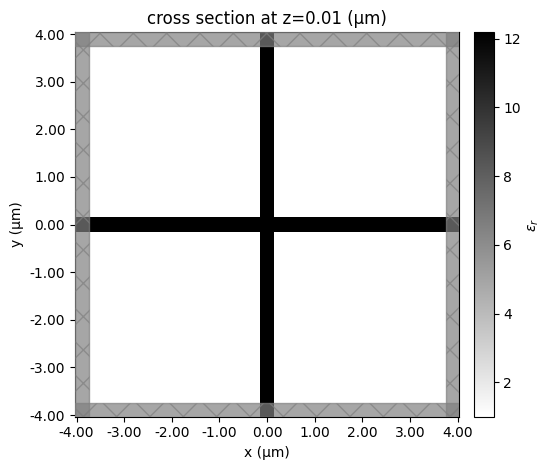

In [4]:
ax = sim_static.plot_eps(z=0.01, freq=freq0)
ax.set_aspect("equal")

### Define design region

Next, we define the design region as a pixelated grid of permittivity values that get generated from our optimization parameters.

We first define the overall geometry as a `td.Box` and also the number of pixels in x and y static on our design region resolution.

In [5]:
nx = (int(lx / dl_design_region) // 2) * 2 + 1
ny = (int(ly / dl_design_region) // 2) * 2 + 1
print(nx, ny)

design_region_geo = td.Box(size=(lx, ly, lz), center=(0, 0, 0))

451 451


Next we write a function to give us the pixelated array as a function of our parameters through our filtering and projection methods, which are used to make the resulting structures easier to fabricate. For more details, refer to our 4th lecture in the [inverse design 101 lecture series](https://www.flexcompute.com/tidy3d/learning-center/inverse-design/), which focuses on fabrication constraints.

We also wrap this function in another one that generates the entire `td.Structure` corresponding to the design region, for convenience later.

> Note: we will enforce here that the design region has both 90 degree rotational symmetry and also x and y mirror symmetry, since we expect the final device to respect these symmetries to work in all orientations.

In [6]:
from tidy3d.plugins.autograd import make_filter_and_project, rescale

filter_project = make_filter_and_project(radius, dl_design_region)


def get_density(params: np.ndarray, beta: float) -> np.ndarray:
    """Get the density of material (0, 1) as a function of the parameters (0,1)"""
    fp0 = filter_project(params, beta=beta)

    # make sure density has 90 degree rotation symmetry
    fp_90 = np.rot90(fp0)
    fp_180 = np.rot90(fp_90)
    fp_270 = np.rot90(fp_180)
    fp_rot_symm = (fp0 + fp_90 + fp_180 + fp_270) / 4.0

    # make sure density has x=0 and y=0 mirror symmetry
    fp_xy_symm_lr = np.fliplr(fp_rot_symm)
    fp_xy_symm_ud = np.flipud(fp_rot_symm)
    fp_xy_symm_lrud = np.flipud(np.fliplr(fp_rot_symm))
    return (fp_rot_symm + fp_xy_symm_lr + fp_xy_symm_ud + fp_xy_symm_lrud) / 4.0


def make_eps(params: np.ndarray, beta: float) -> np.ndarray:
    """Construct density values and rescale them to relative permittivity values between air and silicon."""
    density = get_density(params, beta=beta)
    return rescale(density, 1, n_si**2)


def make_custom_medium(params: np.ndarray, beta: float) -> td.Structure:
    """Make td.Structure containing custom medium with the permittivity data as a function of parameters."""
    eps_data = make_eps(params, beta).reshape((nx, ny, 1))
    return td.Structure.from_permittivity_array(eps_data=eps_data, geometry=design_region_geo)

### Construct Simulation

With all of these functions and variables defined, we can write a single function to return our variable `td.Simulation` as a function of our design parameters. This function first constructs the design region, a mesh override structure to control the resolution in this region, and then creates a copy of the original `td.Simulation` with all of the basic parameters.

In [7]:
def get_sim(params, beta, include_extra_mnts: bool = True):
    design_region = make_custom_medium(params, beta=beta)

    design_override = td.MeshOverrideStructure(
        geometry=design_region.geometry,
        dl=[dl_design_region, dl_design_region, dl_design_region],
    )
    grid_spec = sim_static.grid_spec.updated_copy(
        override_structures=list(sim_static.grid_spec.override_structures) + [design_override]
    )

    update_dict = dict(
        structures=list(sim_static.structures) + [design_region],
        grid_spec=grid_spec,
    )

    # if include_extra_mnts is False, update sim to only include mode monitors, to save data.
    if not include_extra_mnts:
        update_dict["monitors"] = []

    return sim_static.updated_copy(**update_dict)

Let's test out our function. We'll make an initially random array of parameters between 0 and 1 and generate the static simulation to plot and inspect.

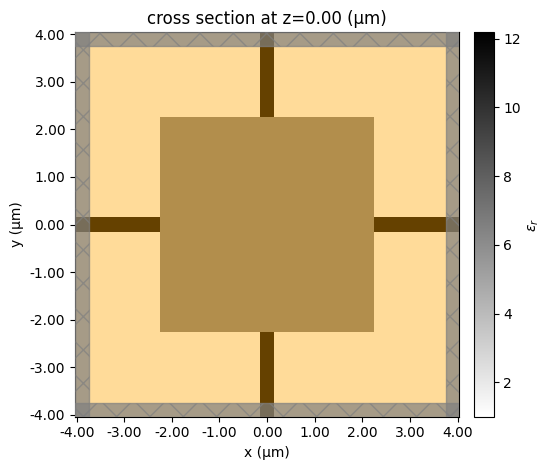

In [8]:
params0 = 0.5 * np.ones((nx, ny))


sim0 = get_sim(params0, beta=100)
sim0.plot_eps(z=0, freq=freq0)
plt.show()

Next we will set up an initial set of parameters to approximate the waveguide crossing represented by two intersecting waveguides. We'll use this as the starting point for our optimization since it already mostly works.

Below we'll import a helper function to set this up automatically by looking at a base `Simulation` object and a parameterization corresponding to the design region `Structure`.

In [9]:
from tidy3d.plugins.autograd.invdes import initialize_params_from_simulation

params0 = initialize_params_from_simulation(
    sim=sim_static,
    param_to_structure=make_custom_medium,
    params0=params0,
    verbose=False,
    beta=10,
)

In [10]:
sim0 = get_sim(params0, beta=10)

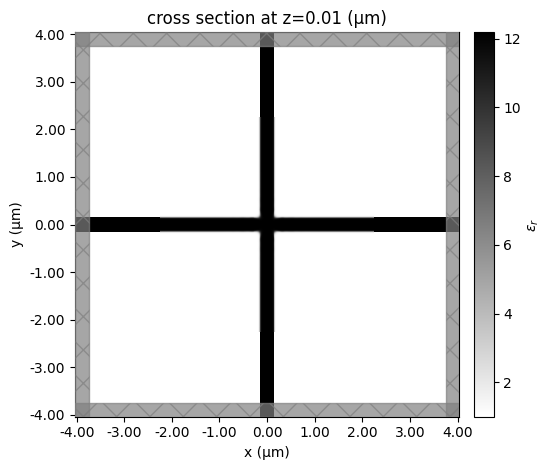

In [11]:
ax = sim0.plot_eps(z=0.01, freq=freq0)
ax.set_aspect("equal")

The simulation with design region and initial parameters looks very similar to our initial waveguide crossing.

### Component Modeler
Next we use the `ComponentModeler` to wrap the `Simulation`, together with a set of `Port` objects, in an object that makes it straighforward to generate scattering matrices. The `ComponentModeler` figures out which simulations need to run for a given specification and can perform parallel processing and final assembly for us. For more details, refer to [this tutorial](https://docs.flexcompute.com/projects/tidy3d/en/latest/notebooks/SMatrix.html).

> Note: we will use `run_only` argument to only compute one column of the scattering matrix, helping save computation time. The structure works the same when turned 90 degrees so we can determine everything we need using the single port excitation + applying symmetry in the design region.

In [12]:
from tidy3d.plugins.smatrix import ModalComponentModeler, Port

# set up the ports
spc = -Lx / 2 + wvl0 / 5

ports = []
for side in "-+":
    for axis, dim in enumerate("xy"):
        center_axis = spc if side == "-" else -spc

        center = td.Box.unpop_axis(center_axis, (0, 0), axis=axis)
        size = td.Box.unpop_axis(0, (lx / 2, td.inf), axis=axis)

        port = Port(
            center=center,
            size=size,
            direction="+" if side == "-" else "-",
            name=f"port_{dim}_{side}",
        )
        ports.append(port)


def get_modeler(params, beta, include_extra_mnts: bool = True):
    """return the ComponentModeler given the parameters"""
    sim = get_sim(params, beta, include_extra_mnts=include_extra_mnts)
    return ModalComponentModeler(
        simulation=sim,
        ports=ports,
        freqs=[freq0],
        run_only=[("port_x_-", 0)],
    )

Let's first plot the fundamental simulation generated by the `ComponentModeler` to verify that everything looks sufficient. 

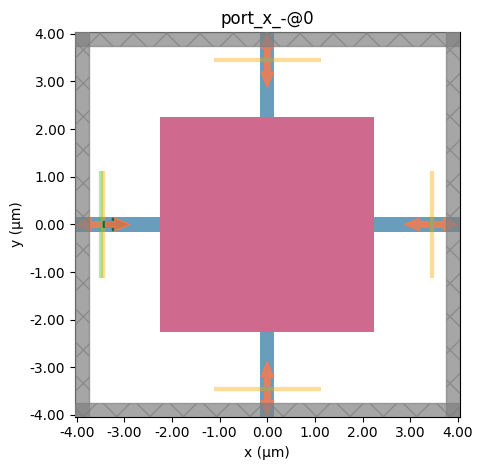

In [13]:
modeler = get_modeler(params0, beta=10, include_extra_mnts=False)

for name, sim in modeler.sim_dict.items():
    ax = sim.plot(z=0)
    ax.set_title(name)

plt.show()

## Defining Objective Function

With our simulation fully defined as a function of our parameters, we are ready to define our objective function.

First, we generate a matrix where the `ij` element represents our "desired" transmission from port `i` to port `j`.

> In this case, since we only need to specify one port due to symmetry, we just describe our desired column of the scattering matrix. But this can be easily generalized to a full scattering matrix.

In [14]:
# the S-matrix column we want
s_matrix_desired = np.array([0.0, 0.0, 1.0, 0.0])
norm = np.linalg.norm(s_matrix_desired)

The next step is writing a python function that combines everything together.

In [15]:
import tidy3d.web as web


def objective(params, beta: float, include_extra_mnts=False, verbose: bool = True) -> float:
    """Construct and run the modeler, then compare S-matrix column to desired."""
    modeler = get_modeler(params, beta=beta, include_extra_mnts=include_extra_mnts)
    modeler_data = web.run(modeler, verbose=verbose, task_name="crossing")
    smatrix = modeler_data.smatrix()
    smatrix = smatrix.sel(port_in="port_x_-")
    smatrix_array = np.abs(smatrix.data.squeeze()) ** 2
    return np.linalg.norm(smatrix_array - s_matrix_desired) / norm

### Differentiating the objective

Finally, we can simply use `autograd` (`ag`) to transform this objective function into a function that returns our objective function value and our gradient, which we will feed to the optimizer.

In [16]:
grad_fn = ag.value_and_grad(objective)

Let's try out our gradient function to verify that it works properly.

In [17]:
J, grad = grad_fn(params0, beta=1)

Output()

Output()

Output()

09:17:28 EDT Started working on Batch containing 1 tasks.

09:17:29 EDT Maximum FlexCredit cost: 0.065 for the whole batch.

             Use 'Batch.real_cost()' to get the billed FlexCredit cost after the
             Batch has completed.

Output()

09:17:30 EDT Batch complete.

Output()

09:17:33 EDT Started working on Batch containing 1 tasks.

09:17:37 EDT Maximum FlexCredit cost: 0.067 for the whole batch.

             Use 'Batch.real_cost()' to get the billed FlexCredit cost after the
             Batch has completed.

Output()

09:18:05 EDT Batch complete.

Output()

In [18]:
print(f"J = {J:.4f}")
print(f"gradient shape = {grad.shape}")
print(f"gradient norm = {np.linalg.norm(grad):.4f}")

J = 0.2659
gradient shape = (451, 451)
gradient norm = 0.0286


## Run Optimization

Finally, we are ready to optimize our device. We will make use of the `optax` package to define an optimizer using the `adam` method, as we've done in the previous inverse design tutorials.

We record a history of objective function values, and parameters, for visualization later.

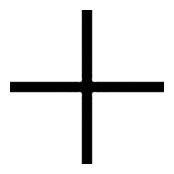

step = 1
	J = 2.8238e-01
	beta = 30.00
	grad_norm = 1.8386e-02


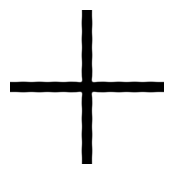

step = 2
	J = 2.2298e-01
	beta = 30.00
	grad_norm = 8.4923e-03


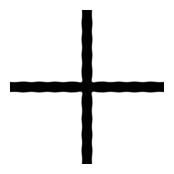

step = 3
	J = 1.9572e-01
	beta = 30.00
	grad_norm = 6.0384e-03


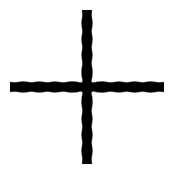

step = 4
	J = 1.7752e-01
	beta = 30.00
	grad_norm = 5.6506e-03


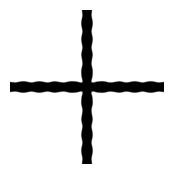

step = 5
	J = 1.6322e-01
	beta = 30.00
	grad_norm = 5.8429e-03


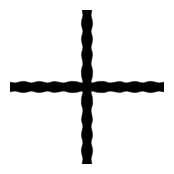

step = 6
	J = 1.4959e-01
	beta = 30.00
	grad_norm = 6.7027e-03


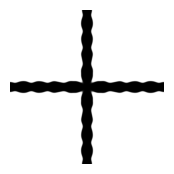

step = 7
	J = 1.3494e-01
	beta = 30.00
	grad_norm = 8.5567e-03


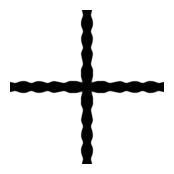

step = 8
	J = 1.1575e-01
	beta = 30.00
	grad_norm = 8.8893e-03


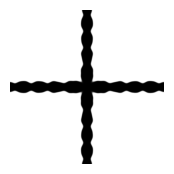

step = 9
	J = 9.3497e-02
	beta = 30.00
	grad_norm = 9.3111e-03


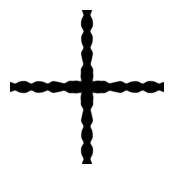

step = 10
	J = 6.8201e-02
	beta = 30.00
	grad_norm = 9.3080e-03


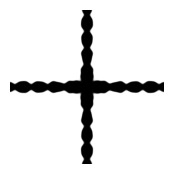

step = 11
	J = 4.9634e-02
	beta = 30.00
	grad_norm = 1.1281e-02


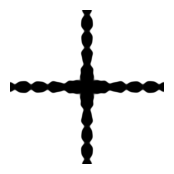

step = 12
	J = 4.2938e-02
	beta = 30.00
	grad_norm = 2.3617e-02


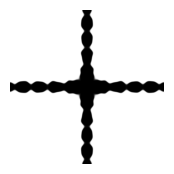

step = 13
	J = 3.4192e-02
	beta = 30.00
	grad_norm = 1.3442e-02


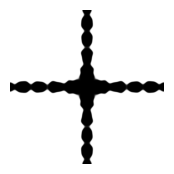

step = 14
	J = 4.8930e-02
	beta = 30.00
	grad_norm = 3.2987e-02


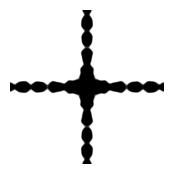

step = 15
	J = 4.5076e-02
	beta = 30.00
	grad_norm = 3.9481e-02


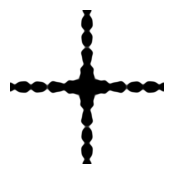

step = 16
	J = 2.9627e-02
	beta = 30.00
	grad_norm = 8.3295e-03


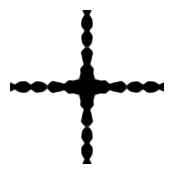

step = 17
	J = 3.1068e-02
	beta = 30.00
	grad_norm = 2.4241e-02


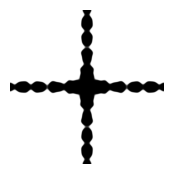

step = 18
	J = 1.9480e-02
	beta = 30.00
	grad_norm = 4.5024e-03


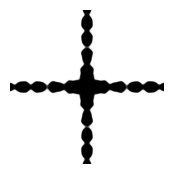

09:46:34 EDT WARNING: No connection: Retrying for 180 seconds.                  

step = 19
	J = 2.4465e-02
	beta = 30.00
	grad_norm = 3.2538e-02


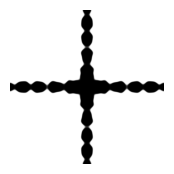

step = 20
	J = 1.7596e-02
	beta = 30.00
	grad_norm = 1.3490e-02


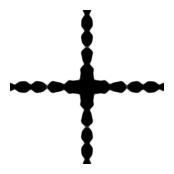

step = 21
	J = 1.9705e-02
	beta = 30.00
	grad_norm = 2.3249e-02


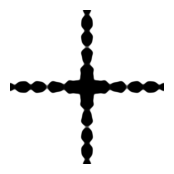

step = 22
	J = 1.5817e-02
	beta = 30.00
	grad_norm = 1.9620e-02


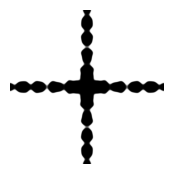

step = 23
	J = 1.2857e-02
	beta = 30.00
	grad_norm = 1.3309e-02


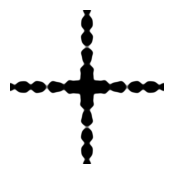

step = 24
	J = 1.5397e-02
	beta = 30.00
	grad_norm = 2.7810e-02


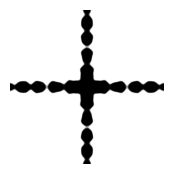

step = 25
	J = 1.0909e-02
	beta = 30.00
	grad_norm = 1.5978e-02


In [19]:
import optax

# hyperparameters
num_steps = 25
learning_rate = 0.05

# we will just have the same projection strength for beginning and end in this case
beta = 30

# initialize adam optimizer with starting parameters
params = params0.copy()

optimizer = optax.adam(learning_rate=learning_rate)
opt_state = optimizer.init(params)

# store history
Js = []
params_history = [params0]
beta_history = []

for i in range(num_steps):
    perc_done = i / (num_steps - 1)

    # make a plot of density to check on progress
    density = get_density(params, beta=beta)
    plt.subplots(figsize=(2, 2))
    plt.imshow(np.flipud(1 - density.T), cmap="gray", vmin=0, vmax=1)
    plt.axis("off")
    plt.show()

    # compute gradient and current objective function value
    value, gradient = grad_fn(params, beta=beta, verbose=False)

    # outputs
    print(f"step = {i + 1}")
    print(f"\tJ = {value:.4e}")
    print(f"\tbeta = {beta:.2f}")
    print(f"\tgrad_norm = {np.linalg.norm(gradient):.4e}")

    # compute and apply updates to the optimizer based on gradient (-1 sign to maximize obj_fn)
    updates, opt_state = optimizer.update(gradient, opt_state, params)
    params[:] = optax.apply_updates(params, updates)

    # keep params between 0 and 1
    np.clip(params, 0.0, 1.0, out=params)

    # save history
    Js.append(value)
    params_history.append(params.copy())

## Visualize Results

Let's visualize the results of our optimization.

### Objective function vs Iteration

First we inspect the objective function value as a function of optimization iteration number. We see that it steadily increases as expected. 

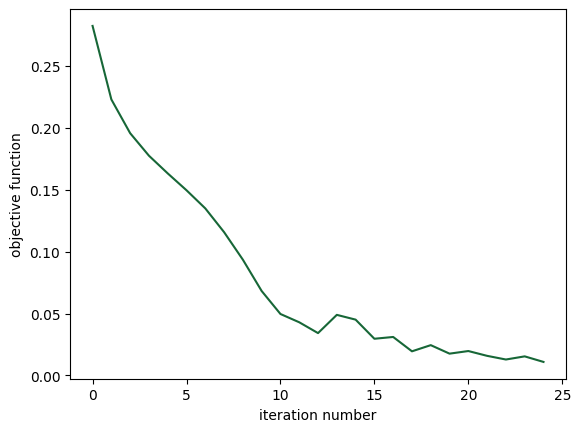

In [20]:
plt.plot(Js)
plt.xlabel("iteration number")
plt.ylabel("objective function")
plt.show()

### Final Device Performance

Now, let's take a closer look at the final, optimized design. We take the best parameters found during the optimization and run the `ComponentModeler` one last time.

In [21]:
# we'll sample the modes at a finer frequency resolution for this final evaluation, for smoother plots
freqs = np.linspace(freq0 - fwidth, freq0 + fwidth, 201)

modeler_start = get_modeler(params_history[0], beta=beta, include_extra_mnts=True).updated_copy(
    freqs=freqs
)
modeler_final = get_modeler(params_history[-1], beta=beta, include_extra_mnts=True).updated_copy(
    freqs=freqs
)

Let's take a look at our final design.

Text(0.5, 1.0, 'final design')

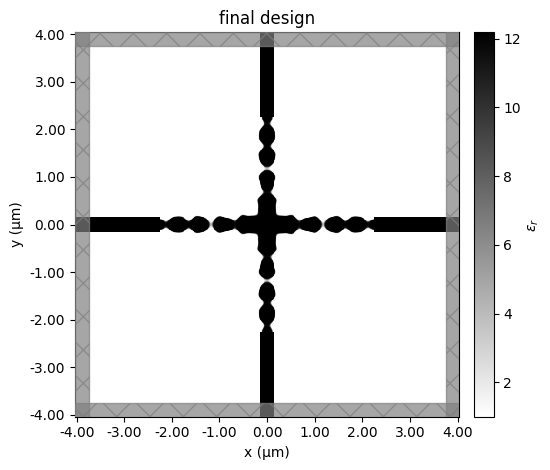

In [22]:
ax = modeler_final.simulation.plot_eps(z=0, monitor_alpha=0, freq=freq0)
ax.set_title("final design")

The field plots below show the device operating at the central design frequency. We can clearly see the crossover behavior: light entering the top-left port is efficiently routed to the bottom-right port, and light from the bottom-left is routed to the top-right.

Output()

09:55:52 EDT Started working on Batch containing 1 tasks.

09:55:53 EDT Maximum FlexCredit cost: 0.134 for the whole batch.

             Use 'Batch.real_cost()' to get the billed FlexCredit cost after the
             Batch has completed.

Output()

09:56:40 EDT Batch complete.

Output()

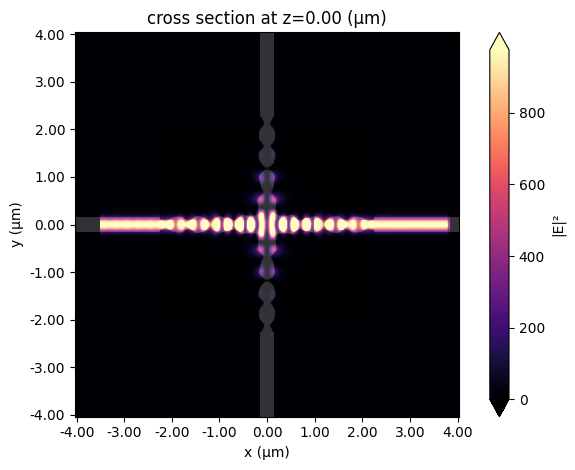

In [23]:
simulations = modeler_final.sim_dict
bd = web.run_async(simulations)
for task_name, sim_data in bd.items():
    sim_data.plot_field(field_monitor_name="field", field_name="E", val="abs^2")

Next, let's look at the S-parameters over a range of frequencies to see how our final device behaves.

In [24]:
smatrix_start = web.run(modeler_start, task_name="start").smatrix()
smatrix_final = web.run(modeler_final, task_name="final").smatrix()

09:56:46 EDT Created task 'start' with resource_id                              
             'sid-df34a742-6a56-491f-9f4c-2632b2c82cbc' and task_type 'RF'.

             View task using web UI at                                          
             ]8;id=13954;https://tidy3d.simulation.cloud/workbench?taskId=sid-df34a742-6a56-491f-9f4c-2632b2c82cbc\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=380254;https://tidy3d.simulation.cloud/workbench?taskId=sid-df34a742-6a56-491f-9f4c-2632b2c82cbc\taskId]8;;\]8;id=13954;https://tidy3d.simulation.cloud/workbench?taskId=sid-df34a742-6a56-491f-9f4c-2632b2c82cbc\=]8;;\]8;id=238595;https://tidy3d.simulation.cloud/workbench?taskId=sid-df34a742-6a56-491f-9f4c-2632b2c82cbc\sid]8;;\]8;id=13954;https://tidy3d.simulation.cloud/workbench?taskId=sid-df34a742-6a56-491f-9f4c-2632b2c82cbc\-df34a742-6a56]8;;\
             ]8;id=13954;https://tidy3d.simulation.cloud/workbench?taskId=sid-df34a742-6a56-491f-9f4c-2632b2c82cbc\-491f-9f4c-2632b2c82cbc']8;;\.

             Task folder: ]8;id=820630;https://tidy3d.simulation.cloud/folders/41078c53-acd3-4f23-98d5-8423bc5401c7\'default']8;;\.

Output()

09:56:49 EDT Child simulation subtasks are being uploaded to                    
             - port_x_-@0: 'rf-b36e4261-6012-4b66-805f-14e162cb4612'

09:56:50 EDT Validating component modeler and subtask simulations...

             Maximum FlexCredit cost: 0.134. Minimum cost depends on task       
             execution details. Use 'web.real_cost(task_id)' to get the billed  
             FlexCredit cost after a simulation run.

09:56:51 EDT Component modeler batch validation has been successful.

             Subtasks status - start                                            
             Group ID: 'pa-80b32ccd-ee55-41e2-9409-3eedb5252ded'

Output()

09:57:47 EDT Modeler has finished running successfully.

09:57:48 EDT Billed FlexCredit cost: 0.086. Minimum cost depends on task        
             execution details. Use 'web.real_cost(task_id)' to get the billed  
             FlexCredit cost after a simulation run.

Output()

09:57:50 EDT loading component modeler data from ./cm_data.hdf5

             Created task 'final' with resource_id                              
             'sid-a5113da9-103b-40f3-bf9a-8d7fb8599e65' and task_type 'RF'.

             View task using web UI at                                          
             ]8;id=923871;https://tidy3d.simulation.cloud/workbench?taskId=sid-a5113da9-103b-40f3-bf9a-8d7fb8599e65\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=426511;https://tidy3d.simulation.cloud/workbench?taskId=sid-a5113da9-103b-40f3-bf9a-8d7fb8599e65\taskId]8;;\]8;id=923871;https://tidy3d.simulation.cloud/workbench?taskId=sid-a5113da9-103b-40f3-bf9a-8d7fb8599e65\=]8;;\]8;id=826247;https://tidy3d.simulation.cloud/workbench?taskId=sid-a5113da9-103b-40f3-bf9a-8d7fb8599e65\sid]8;;\]8;id=923871;https://tidy3d.simulation.cloud/workbench?taskId=sid-a5113da9-103b-40f3-bf9a-8d7fb8599e65\-a5113da9-103b]8;;\
             ]8;id=923871;https://tidy3d.simulation.cloud/workbench?taskId=sid-a5113da9-103b-40f3-bf9a-8d7fb8599e65\-40f3-bf9a-8d7fb8599e65']8;;\.

             Task folder: ]8;id=306032;https://tidy3d.simulation.cloud/folders/41078c53-acd3-4f23-98d5-8423bc5401c7\'default']8;;\.

Output()

09:57:53 EDT Child simulation subtasks are being uploaded to                    
             - port_x_-@0: 'rf-63060054-b8f3-4678-9866-a0564cddebe8'

             Validating component modeler and subtask simulations...

09:57:54 EDT Maximum FlexCredit cost: 0.134. Minimum cost depends on task       
             execution details. Use 'web.real_cost(task_id)' to get the billed  
             FlexCredit cost after a simulation run.

             Component modeler batch validation has been successful.

09:57:55 EDT Subtasks status - final                                            
             Group ID: 'pa-6dfb45bf-f1ad-40b4-9986-85c9d54914d4'

Output()

09:59:53 EDT Modeler has finished running successfully.

             Billed FlexCredit cost: 0.096. Minimum cost depends on task        
             execution details. Use 'web.real_cost(task_id)' to get the billed  
             FlexCredit cost after a simulation run.

Output()

09:59:56 EDT loading component modeler data from ./cm_data.hdf5

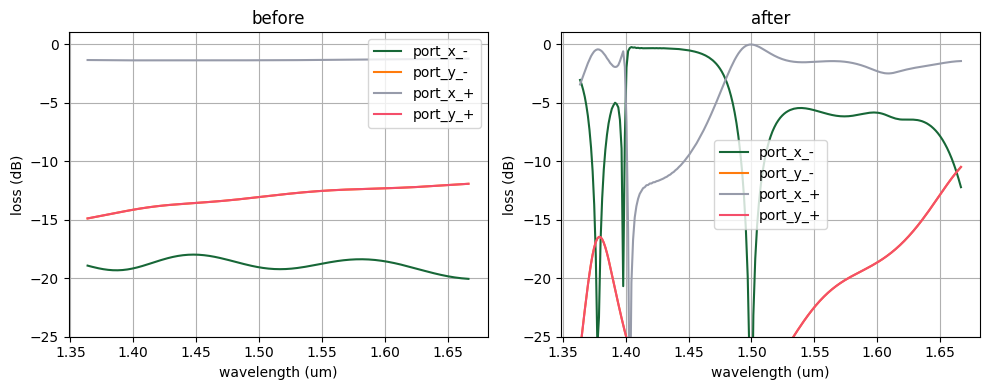

In [35]:
_, axes = plt.subplots(1, 2, tight_layout=True, figsize=(10, 4))

wvs = td.C_0 / freqs

for ax, smatrix, label in zip(axes, [smatrix_start, smatrix_final], ["before", "after"]):
    for port in ports:
        amps = smatrix.sel(port_in=ports[0].name, port_out=port.name).data.squeeze()
        ts = np.abs(amps) ** 2
        loss = 10 * np.log10(ts)
        ax.plot(wvs, loss, label=f"{port.name}")
        ax.set_title(label)
        ax.set_ylim([-25, 1])
        ax.set_ylabel("loss (dB)")
        ax.set_xlabel("wavelength (um)")
        ax.grid("on")
        ax.legend()
plt.show()

As we can see, through transmission is very low loss whereas the transmission to the side ports is suppressed. 

In [36]:
abs(smatrix_final.interp(f=freq0).data.squeeze()) ** 2

array([2.34935260e-04, 8.71454911e-04, 9.90924129e-01, 8.71589045e-04])